In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector
from qiskit.compiler import transpile, assemble
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from numpy import pi
import numpy as np

# Étape 1 : Initialisation avec Hadamard

On initialise les qubits à $\ket{0}$, sauf celui lié à l'oracle que l'on inverse pour initialisé à $\ket{1}$.

On initialise l'algorithme en superposants tout les états des qubits, afin de les tester simultanement dans l'oracle (cf Etape 2).

On à donc en sortie de cette étape :
$$\ket{\psi_{0}} = H^{\otimes n+1} \ket{0} \otimes \ket{1} \\ = (H \ket{0})^{\otimes n} \otimes H\ket{1}$$
On pose classiquement $\ket{p} = H\ket{0}$ et $\ket{m} = H\ket{1}$

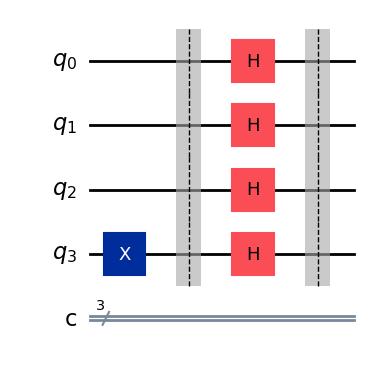

In [2]:
n_qubits = 3
n_bits = 3
grover_circuit = QuantumCircuit(n_qubits+1, n_bits)
grover_circuit.x(n_qubits)
grover_circuit.barrier()
grover_circuit.h(range(n_qubits+1))
grover_circuit.barrier()

grover_circuit.draw('mpl')

# Etape 2 : Implementation de l'oracle

Nous allons ici définir un Oracle qui va marquer l'état : $\ket{101}$.

Ce genre d'oracle peut etre décomposé en trois étape :
- etape 1 : On change de base pour que notre nouvelle base projette l'état cible dans la diagonale.
- etape 2 : On marque cet état avec un operateur CCCX.
- etape 3 : On change à nouveau la base pour retourner dans la base initiale.

$$\ket{\psi_{1}} = (I \otimes X \otimes I \otimes I) CCCX (I \otimes X \otimes I \otimes I)\ket{\psi_{0}}$$

Aprés calcul on à :

$$\ket{\psi_{1}} = (\ket{p}^{\otimes 3} - \frac{\sqrt{2}}{2}\ket{101}) \otimes \ket{m}$$

Par la suite inutile de garder $\ket{m}$ ce qubit ne sera plus jamais modifié. On reduit la dimension du qubit $psi$ de 1

On notera abusivement : 

$$\ket{\psi_{1}} = (\ket{p}^{\otimes 3} - \frac{\sqrt{2}}{2}\ket{101})$$


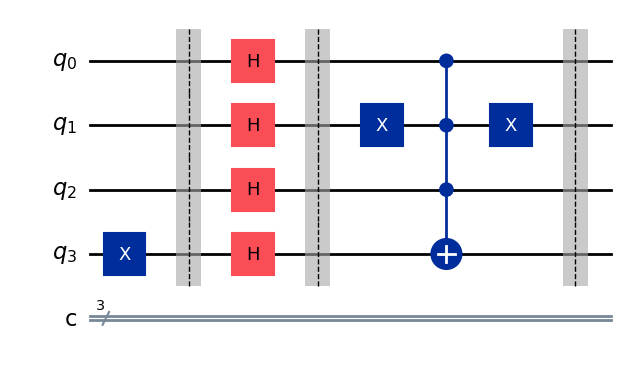

In [3]:
def oracle(circuit):
    circuit.x(1)

    circuit.mcx(list(range(3)), 3)
    
    circuit.x(1)
    
    return circuit

grover_circuit = oracle(grover_circuit)
grover_circuit.barrier()

grover_circuit.draw('mpl')

# Etape 3 : Amplification de l’amplitude

Changement de base puis porte controlé CCCZ Pour amplifier l'état souhaité.

$$\ket{\psi_{2}} = (H^{\otimes 3}X^{\otimes 3})CCCZ(X^{\otimes 3}H^{\otimes 3}) \ket{\psi_{1}}$$

On a aprés calcul :

$$\ket{\psi_{2}} = \frac{1}{2}\ket{p}^{\otimes 3} + \frac{\sqrt{2}}{2} \ket{101}$$


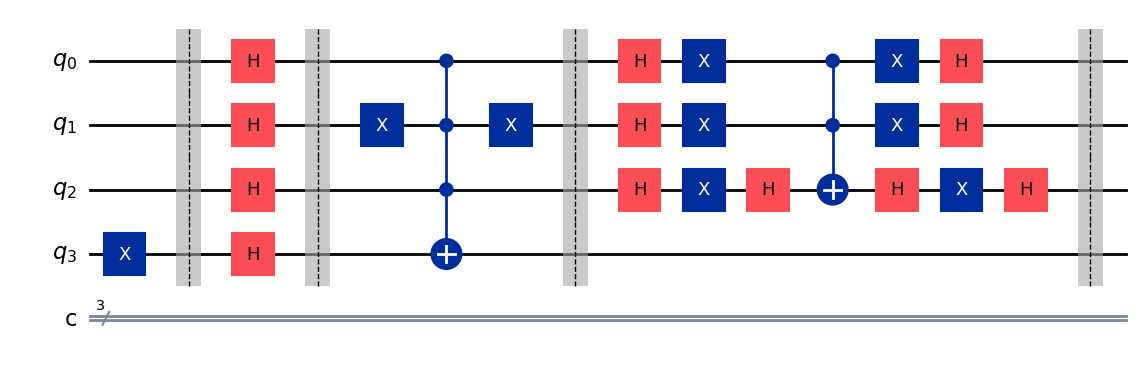

In [4]:
def diffusion_operator(circuit, n):
    circuit.h(range(n))
    circuit.x(range(n))
    circuit.h(n - 1)
    circuit.mcx(list(range(n - 1)), n - 1)  # Contrôle multiple sur tous les qubits sauf le dernier
    circuit.h(n - 1)
    circuit.x(range(n))
    circuit.h(range(n))
    return circuit

grover_circuit = diffusion_operator(grover_circuit, n_qubits)
grover_circuit.barrier()

grover_circuit.draw('mpl')

# Etape 4 :  Mesure

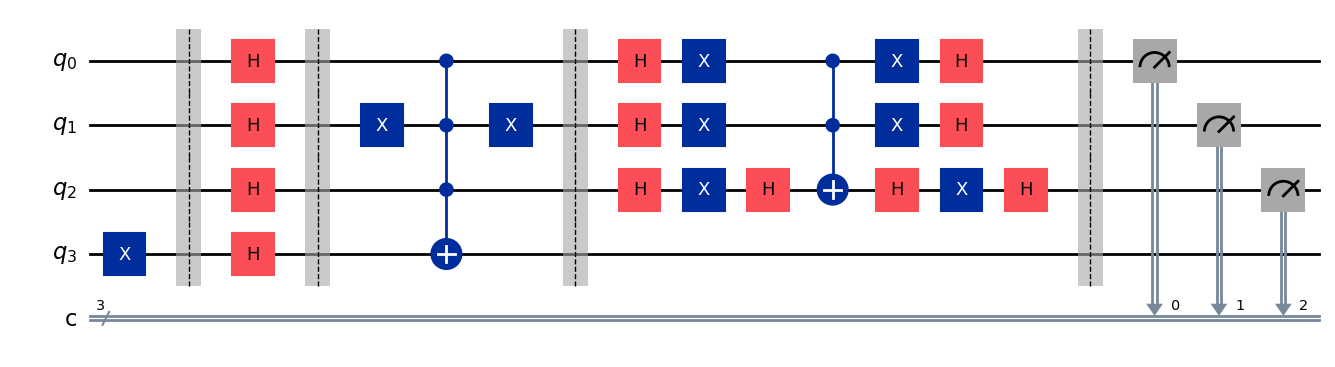

In [5]:
grover_circuit.measure(range(n_qubits), range(n_bits))

grover_circuit.draw('mpl')

# Etape 5 : Execution

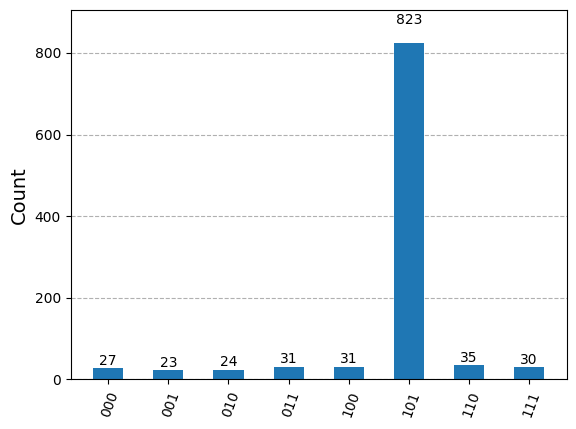

In [6]:
backend = AerSimulator()
transpiled_grover_circuit = transpile(grover_circuit, backend)
job = backend.run(transpiled_grover_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

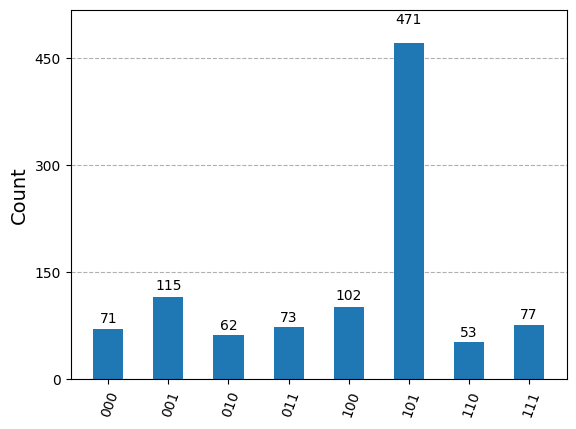

In [7]:
backend = FakeManilaV2()
transpiled_grover_circuit = transpile(grover_circuit, backend)
job = backend.run(transpiled_grover_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

# Généralisation

Compilons maintenant ces étapes en un programmes qui prend en argument le circuit correspondant à l'oracle.

In [8]:
def grover(n_qubits, n_bits, oracle, iter=1):

    #initialisation
    grover_circuit = QuantumCircuit(n_qubits+1, n_bits)
    grover_circuit.x(n_qubits)
    grover_circuit.barrier()
    grover_circuit.h(range(n_qubits+1))
    grover_circuit.barrier()

    for _ in range(iter):
        #ajout de l'oracle
        grover_circuit.append(oracle, range(n_qubits+1))
        grover_circuit.barrier()
            
        #amplification
        diffusion_operator(grover_circuit, n_qubits)
        grover_circuit.barrier()

    #mesure
    grover_circuit.measure(range(n_qubits), range(n_bits))

    return grover_circuit 

Essayons de créer un générateur d'oracle

Pour changer de base nous utiliserons l'opérateur : $(X \otimes ...\otimes I \otimes X \otimes I)$ où I remplace $\ket{1}$ et X remplace $\ket{0}$.

Nous appliquons ensuite la porte CX de meme dimension que les qubits en entrée.


In [9]:
def oracle_generator(n_qubits, target_state):
    oracle = QuantumCircuit(n_qubits+1, name='oracle')
    
    target_binary = f"{target_state:0{n_qubits}b}"[::-1]
    
    for qubit, bit in enumerate(target_binary):
        if bit == '0':
            oracle.x(qubit)
            
    oracle.mcx(list(range(n_qubits)), n_qubits)
    
    for qubit, bit in enumerate(target_binary):
        if bit == '0':
            oracle.x(qubit)
    
    return oracle


état cible 2 i.e. 010


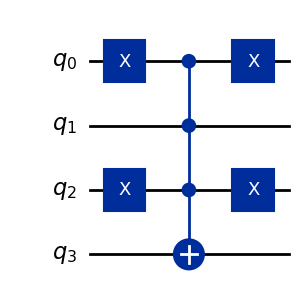

In [10]:
n_qubits = 3
target_state = np.random.randint(0, 2**n_qubits)
print("état cible",target_state, "i.e.",f"{target_state:0{n_qubits}b}")
oracle = oracle_generator(n_qubits, target_state)

oracle.draw('mpl')

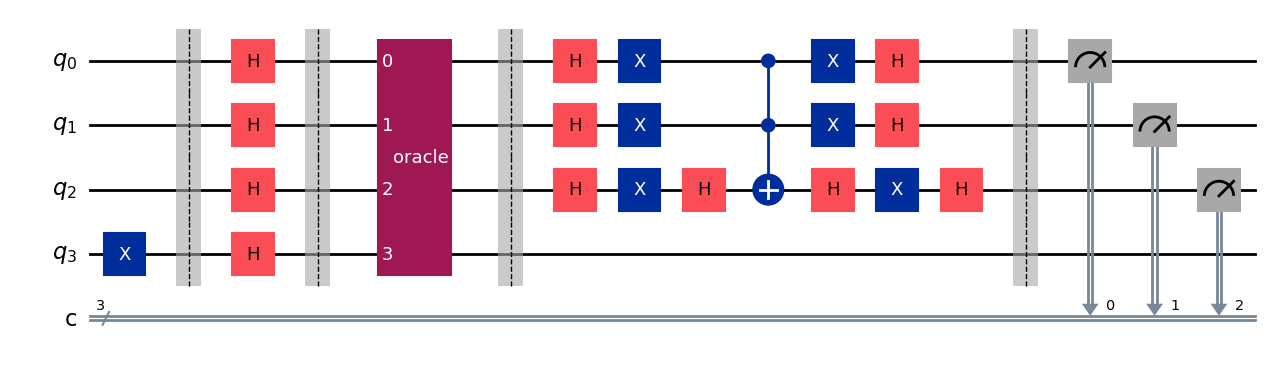

In [11]:
import math
n_bits = n_qubits
#iter = math.ceil(pi/4 * np.sqrt(n_qubits))
grover_circuit = grover(n_qubits, n_bits, oracle)
grover_circuit.draw('mpl')

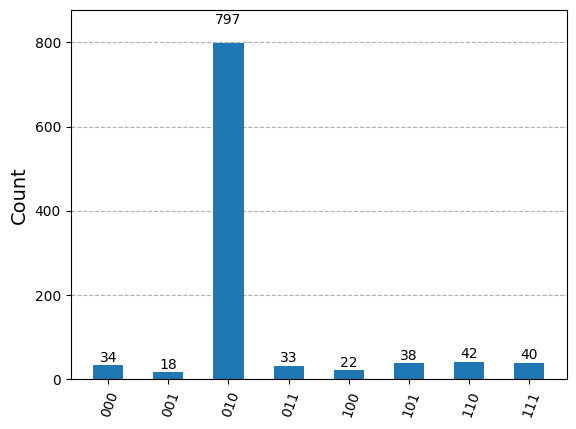

In [12]:
backend = AerSimulator()
transpiled_grover_circuit = transpile(grover_circuit, backend)
job = backend.run(transpiled_grover_circuit, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

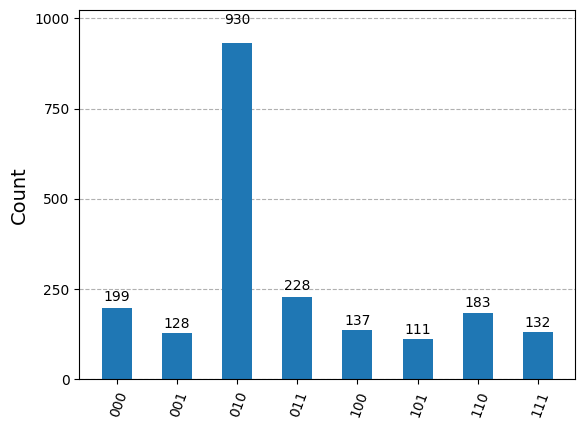

In [13]:
backend = FakeManilaV2()
transpiled_grover_circuit = transpile(grover_circuit, backend)
job = backend.run(transpiled_grover_circuit, shots=2048)
counts = job.result().get_counts()
plot_histogram(counts)